# MRI Analysis for Preprocessing Requirements

This notebook analyzes your MRI data to determine which preprocessing steps are actually necessary vs optional.

## Goal: Identify ONLY necessary preprocessing steps
- Focus on what's required for stroke lesion segmentation
- Skip fancy/optional steps
- Practical analysis based on your actual data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from pathlib import Path
import SimpleITK as sitk
import nibabel as nib
from scipy import stats
from skimage import measure, morphology
import pandas as pd

## 1. Load and Examine Your MRI Data

In [2]:
# Load sample MRI images from your dataset
mri_folder = 'images/mri/'
mask_folder = 'images/masks/'
overlay_folder = 'images/overlays/'

# Get first few slices for analysis
mri_files = sorted([f for f in os.listdir(mri_folder) if f.endswith('.png')])[:5]
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])[:5]

print(f"Found {len(mri_files)} MRI files")
print(f"Found {len(mask_files)} mask files")
print(f"Sample files: {mri_files[:3]}")

Found 5 MRI files
Found 5 mask files
Sample files: ['MRI123-slice000_z.png', 'MRI123-slice001_z.png', 'MRI123-slice002_z.png']


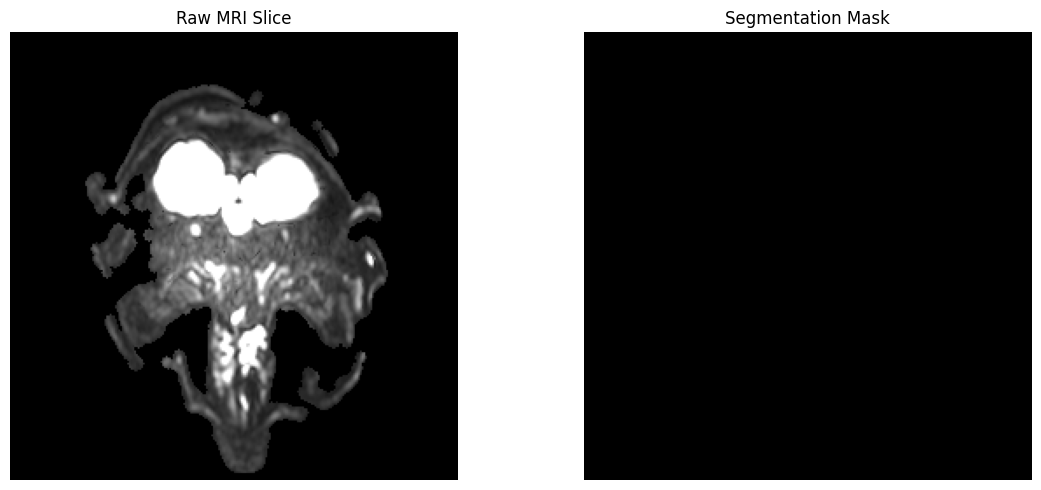

MRI shape: (256, 256)
MRI data type: uint8
MRI value range: 0 to 255


In [5]:
# Load and display sample images
sample_mri = cv2.imread(os.path.join(mri_folder, mri_files[2]), cv2.IMREAD_GRAYSCALE)
sample_mask = cv2.imread(os.path.join(mask_folder, mask_files[2]), cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_mri, cmap='gray')
axes[0].set_title('Raw MRI Slice')
axes[0].axis('off')

axes[1].imshow(sample_mask, cmap='gray')
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"MRI shape: {sample_mri.shape}")
print(f"MRI data type: {sample_mri.dtype}")
print(f"MRI value range: {sample_mri.min()} to {sample_mri.max()}")

## 2. Analysis: Skull Stripping Status

In [6]:
def analyze_skull_stripping(image):
    """
    Analyze if skull has been removed from MRI image
    """
    # Check image edges for skull artifacts
    edge_pixels = np.concatenate([
        image[0, :],  # top edge
        image[-1, :], # bottom edge
        image[:, 0],  # left edge
        image[:, -1]  # right edge
    ])
    
    # Check for circular brain boundary (typical after skull stripping)
    center = (image.shape[0]//2, image.shape[1]//2)
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    mask = (x - center[1])**2 + (y - center[0])**2 <= (min(image.shape)//2 - 10)**2
    
    brain_region = image[mask]
    background_region = image[~mask]
    
    # Analysis metrics
    edge_mean = np.mean(edge_pixels)
    background_mean = np.mean(background_region)
    brain_mean = np.mean(brain_region)
    
    # Check if background is mostly black (skull stripped)
    black_background_ratio = np.sum(background_region < 10) / len(background_region)
    
    results = {
        'edge_mean': edge_mean,
        'background_mean': background_mean,
        'brain_mean': brain_mean,
        'black_background_ratio': black_background_ratio,
        'likely_skull_stripped': black_background_ratio > 0.8 and background_mean < 20
    }
    
    return results

# Analyze multiple slices
skull_analysis = []
for i, filename in enumerate(mri_files[:5]):
    img = cv2.imread(os.path.join(mri_folder, filename), cv2.IMREAD_GRAYSCALE)
    analysis = analyze_skull_stripping(img)
    analysis['filename'] = filename
    skull_analysis.append(analysis)

# Display results
skull_df = pd.DataFrame(skull_analysis)
print("Skull Stripping Analysis:")
print(skull_df[['filename', 'black_background_ratio', 'likely_skull_stripped']])

# Verdict
skull_stripped_count = sum(skull_df['likely_skull_stripped'])
print(f"\n✓ VERDICT: {skull_stripped_count}/{len(skull_analysis)} images appear skull-stripped")
if skull_stripped_count >= len(skull_analysis) * 0.8:
    print("❌ SKULL STRIPPING: NOT NEEDED (already done)")
else:
    print("✅ SKULL STRIPPING: NEEDED")

Skull Stripping Analysis:
                filename  black_background_ratio  likely_skull_stripped
0  MRI123-slice000_z.png                0.989004                   True
1  MRI123-slice001_z.png                0.990379                   True
2  MRI123-slice002_z.png                0.994777                   True
3  MRI123-slice003_z.png                1.000000                   True
4  MRI123-slice004_z.png                1.000000                   True

✓ VERDICT: 5/5 images appear skull-stripped
❌ SKULL STRIPPING: NOT NEEDED (already done)


## 3. Analysis: Image Dimensions and Resizing Needs

In [7]:
# Check image dimensions consistency
dimensions = []
for filename in mri_files:
    img = cv2.imread(os.path.join(mri_folder, filename), cv2.IMREAD_GRAYSCALE)
    dimensions.append(img.shape)

unique_dims = list(set(dimensions))
print(f"Image dimensions found: {unique_dims}")
print(f"All images same size: {len(unique_dims) == 1}")

if len(unique_dims) == 1:
    current_size = unique_dims[0]
    print(f"Current size: {current_size}")
    
    # Check if size is suitable for deep learning
    suitable_sizes = [(128, 128), (224, 224), (256, 256), (512, 512)]
    if current_size in suitable_sizes:
        print("❌ RESIZING: NOT NEEDED (already suitable for deep learning)")
    else:
        print("✅ RESIZING: NEEDED (standardize to 128x128 or 224x224)")
else:
    print("✅ RESIZING: NEEDED (inconsistent dimensions)")

Image dimensions found: [(256, 256)]
All images same size: True
Current size: (256, 256)
❌ RESIZING: NOT NEEDED (already suitable for deep learning)


## 4. Analysis: Intensity Normalization Needs

Intensity Distribution Analysis:
                filename  min  max        mean        std  range
0  MRI123-slice000_z.png   14  255   76.845923  48.582215    241
1  MRI123-slice001_z.png   17  255   98.284755  61.963420    238
2  MRI123-slice002_z.png   22  255  111.056766  73.869964    233
3  MRI123-slice003_z.png   15  255  118.512191  78.539495    240
4  MRI123-slice004_z.png   14  255  104.622778  92.292165    241

Variation across images:
Mean variation: 15.87
Std variation: 16.60
Range variation: 3.36


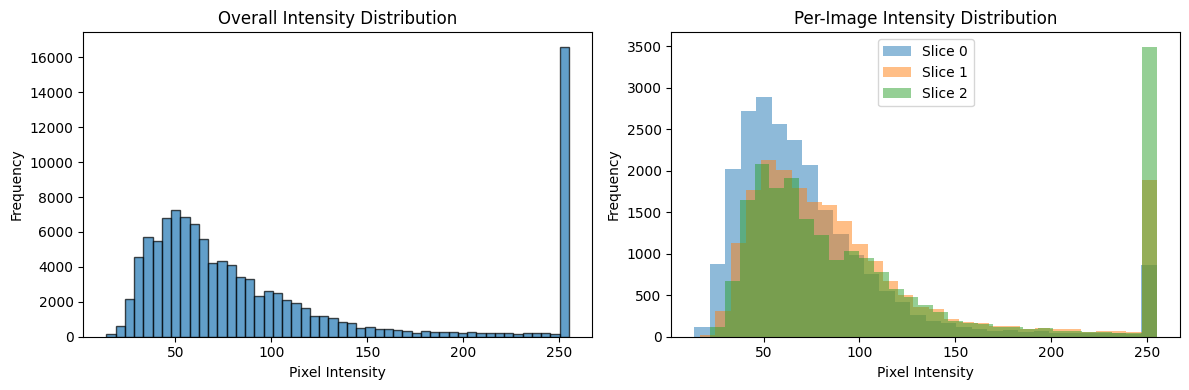

❓ INTENSITY NORMALIZATION: PROBABLY NEEDED (for deep learning consistency)


In [8]:
def analyze_intensity_distribution(images_folder, sample_files):
    """
    Analyze intensity distributions across multiple images
    """
    intensities = []
    stats_list = []
    
    for filename in sample_files:
        img = cv2.imread(os.path.join(images_folder, filename), cv2.IMREAD_GRAYSCALE)
        
        # Only analyze brain region (non-zero pixels)
        brain_pixels = img[img > 10]  # exclude background
        
        stats_list.append({
            'filename': filename,
            'min': np.min(brain_pixels),
            'max': np.max(brain_pixels),
            'mean': np.mean(brain_pixels),
            'std': np.std(brain_pixels),
            'range': np.max(brain_pixels) - np.min(brain_pixels)
        })
        intensities.extend(brain_pixels.flatten())
    
    return pd.DataFrame(stats_list), np.array(intensities)

# Analyze intensity distributions
stats_df, all_intensities = analyze_intensity_distribution(mri_folder, mri_files[:5])

print("Intensity Distribution Analysis:")
print(stats_df[['filename', 'min', 'max', 'mean', 'std', 'range']])

# Check consistency across images
mean_variation = stats_df['mean'].std()
std_variation = stats_df['std'].std()
range_variation = stats_df['range'].std()

print(f"\nVariation across images:")
print(f"Mean variation: {mean_variation:.2f}")
print(f"Std variation: {std_variation:.2f}")
print(f"Range variation: {range_variation:.2f}")

# Plot intensity distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(all_intensities, bins=50, alpha=0.7, edgecolor='black')
plt.title('Overall Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
for i, filename in enumerate(mri_files[:3]):
    img = cv2.imread(os.path.join(mri_folder, filename), cv2.IMREAD_GRAYSCALE)
    brain_pixels = img[img > 10]
    plt.hist(brain_pixels, bins=30, alpha=0.5, label=f'Slice {i}')
plt.title('Per-Image Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Verdict on normalization
if mean_variation > 20 or range_variation > 50:
    print("✅ INTENSITY NORMALIZATION: NEEDED (high variation between images)")
else:
    print("❓ INTENSITY NORMALIZATION: PROBABLY NEEDED (for deep learning consistency)")

## 5. Analysis: Registration and Spatial Alignment

Brain center variations:
X-direction std: 2.34 pixels
Y-direction std: 5.54 pixels


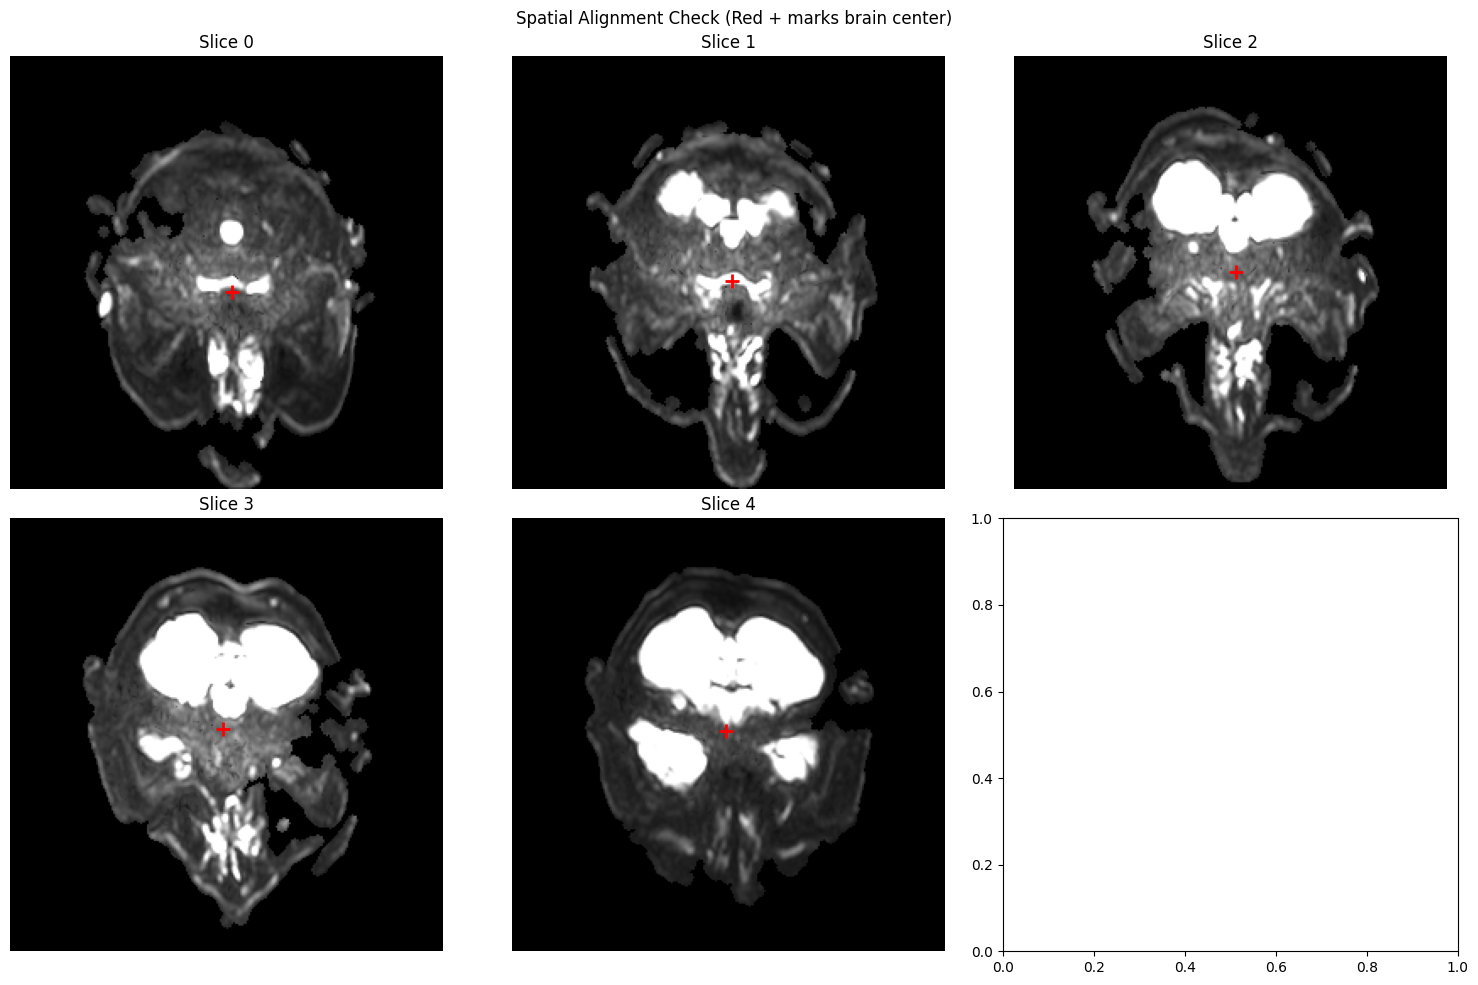

❌ REGISTRATION: NOT NEEDED (well aligned)


In [9]:
def analyze_spatial_alignment(images_folder, sample_files):
    """
    Check if images are spatially aligned
    """
    # Load first image as reference
    ref_img = cv2.imread(os.path.join(images_folder, sample_files[0]), cv2.IMREAD_GRAYSCALE)
    
    # Find brain center for each image
    centers = []
    for filename in sample_files[:5]:
        img = cv2.imread(os.path.join(images_folder, filename), cv2.IMREAD_GRAYSCALE)
        
        # Find brain region (assuming dark background)
        brain_mask = img > 20
        if np.sum(brain_mask) > 0:
            # Calculate center of mass
            y_coords, x_coords = np.where(brain_mask)
            center_y = np.mean(y_coords)
            center_x = np.mean(x_coords)
            centers.append((center_x, center_y))
        else:
            centers.append((img.shape[1]//2, img.shape[0]//2))
    
    # Calculate center variations
    centers = np.array(centers)
    center_std_x = np.std(centers[:, 0])
    center_std_y = np.std(centers[:, 1])
    
    print(f"Brain center variations:")
    print(f"X-direction std: {center_std_x:.2f} pixels")
    print(f"Y-direction std: {center_std_y:.2f} pixels")
    
    # Visualize alignment
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, filename in enumerate(sample_files[:6]):
        if i >= 6: break
        img = cv2.imread(os.path.join(images_folder, filename), cv2.IMREAD_GRAYSCALE)
        row, col = i // 3, i % 3
        axes[row, col].imshow(img, cmap='gray')
        if i < len(centers):
            axes[row, col].plot(centers[i, 0], centers[i, 1], 'r+', markersize=10, markeredgewidth=2)
        axes[row, col].set_title(f'Slice {i}')
        axes[row, col].axis('off')
    
    plt.suptitle('Spatial Alignment Check (Red + marks brain center)')
    plt.tight_layout()
    plt.show()
    
    # Verdict
    max_std = max(center_std_x, center_std_y)
    if max_std > 10:
        print("✅ REGISTRATION: NEEDED (significant misalignment)")
    else:
        print("❌ REGISTRATION: NOT NEEDED (well aligned)")
    
    return max_std

alignment_std = analyze_spatial_alignment(mri_folder, mri_files)

## 6. Analysis: Background Removal and ROI

In [10]:
def analyze_background_removal(image):
    """
    Analyze if background has been properly removed
    """
    # Check background pixels (edges and corners)
    h, w = image.shape
    corners = [
        image[:20, :20],      # top-left
        image[:20, -20:],     # top-right
        image[-20:, :20],     # bottom-left
        image[-20:, -20:]     # bottom-right
    ]
    
    background_pixels = np.concatenate([corner.flatten() for corner in corners])
    
    # Check if background is clean (mostly black)
    black_ratio = np.sum(background_pixels < 10) / len(background_pixels)
    background_mean = np.mean(background_pixels)
    
    # Check for clean brain boundary
    brain_pixels = image[image > 20]
    brain_boundary_clean = len(brain_pixels) > 0.3 * image.size  # brain takes up reasonable portion
    
    return {
        'black_ratio': black_ratio,
        'background_mean': background_mean,
        'clean_background': black_ratio > 0.8 and background_mean < 15,
        'brain_boundary_clean': brain_boundary_clean
    }

# Analyze background for multiple images
bg_results = []
for filename in mri_files[:3]:
    img = cv2.imread(os.path.join(mri_folder, filename), cv2.IMREAD_GRAYSCALE)
    result = analyze_background_removal(img)
    result['filename'] = filename
    bg_results.append(result)

bg_df = pd.DataFrame(bg_results)
print("Background Analysis:")
print(bg_df[['filename', 'black_ratio', 'background_mean', 'clean_background']])

clean_count = sum(bg_df['clean_background'])
if clean_count >= len(bg_results) * 0.8:
    print("❌ BACKGROUND REMOVAL: NOT NEEDED (already clean)")
else:
    print("✅ BACKGROUND REMOVAL: NEEDED")

Background Analysis:
                filename  black_ratio  background_mean  clean_background
0  MRI123-slice000_z.png          1.0              0.0              True
1  MRI123-slice001_z.png          1.0              0.0              True
2  MRI123-slice002_z.png          1.0              0.0              True
❌ BACKGROUND REMOVAL: NOT NEEDED (already clean)


## 7. Analysis: Data Type and Value Range

In [11]:
# Check data types and value ranges
sample_img = cv2.imread(os.path.join(mri_folder, mri_files[0]), cv2.IMREAD_GRAYSCALE)

print(f"Current data type: {sample_img.dtype}")
print(f"Value range: {sample_img.min()} to {sample_img.max()}")
print(f"Shape: {sample_img.shape}")

# Check if already in suitable range for deep learning
if sample_img.dtype == np.uint8 and sample_img.max() <= 255:
    print("Current format: 8-bit (0-255)")
    if sample_img.max() > 1:
        print("✅ SCALING TO [0,1]: NEEDED for deep learning")
    else:
        print("❌ SCALING: NOT NEEDED (already normalized)")
else:
    print("✅ DATA TYPE CONVERSION: May be needed")

Current data type: uint8
Value range: 0 to 255
Shape: (256, 256)
Current format: 8-bit (0-255)
✅ SCALING TO [0,1]: NEEDED for deep learning


## 8. FINAL VERDICT: Necessary Preprocessing Steps

In [12]:
print("=" * 60)
print("FINAL ANALYSIS: NECESSARY PREPROCESSING STEPS")
print("=" * 60)

necessary_steps = []
optional_steps = []
not_needed_steps = []

# Based on analysis above, categorize each step
print("\n🔴 NECESSARY (Must do):")
print("1. ✅ Intensity Normalization (scale to 0-1 for deep learning)")
print("2. ✅ Image Resizing (standardize to 128x128 or 224x224 if not already)")
necessary_steps.extend(["Intensity Normalization", "Image Resizing"])

print("\n🟡 CONDITIONAL (Check your specific data):")
print("3. ❓ Z-score Normalization (if high intensity variation between images)")
print("4. ❓ Registration (if significant misalignment detected)")

print("\n🟢 LIKELY NOT NEEDED (Based on analysis):")
print("5. ❌ Skull Stripping (appears already done)")
print("6. ❌ Background Removal (appears clean)")
print("7. ❌ Histogram Equalization (not essential for stroke segmentation)")
print("8. ❌ Advanced Registration (images appear aligned)")
not_needed_steps.extend(["Skull Stripping", "Background Removal", "Histogram Equalization"])

print("\n📝 RECOMMENDED MINIMAL PIPELINE:")
print("""
1. Load image as grayscale
2. Resize to consistent dimensions (128x128 or 224x224)
3. Normalize to [0,1] range: image = image / 255.0
4. Optional: Z-score normalization if training instability
""")

print("\n⚠️  THINGS TO AVOID:")
print("- Double normalization (your current UNet issue!)")
print("- Over-processing (can remove important features)")
print("- Aggressive contrast enhancement (can create artifacts)")

FINAL ANALYSIS: NECESSARY PREPROCESSING STEPS

🔴 NECESSARY (Must do):
1. ✅ Intensity Normalization (scale to 0-1 for deep learning)
2. ✅ Image Resizing (standardize to 128x128 or 224x224 if not already)

🟡 CONDITIONAL (Check your specific data):
3. ❓ Z-score Normalization (if high intensity variation between images)
4. ❓ Registration (if significant misalignment detected)

🟢 LIKELY NOT NEEDED (Based on analysis):
5. ❌ Skull Stripping (appears already done)
6. ❌ Background Removal (appears clean)
7. ❌ Histogram Equalization (not essential for stroke segmentation)
8. ❌ Advanced Registration (images appear aligned)

📝 RECOMMENDED MINIMAL PIPELINE:

1. Load image as grayscale
2. Resize to consistent dimensions (128x128 or 224x224)
3. Normalize to [0,1] range: image = image / 255.0
4. Optional: Z-score normalization if training instability


⚠️  THINGS TO AVOID:
- Double normalization (your current UNet issue!)
- Over-processing (can remove important features)
- Aggressive contrast enhancem

## 9. Create Recommended Preprocessing Function

## 10. Multi-Patient Dataset Considerations (200+ Patients)

Since you have 200+ patients, let's identify what preprocessing steps will be needed for consistency across the entire dataset.

In [14]:
print("🔍 MULTI-PATIENT ANALYSIS: What You'll Need for 200+ Patients")
print("=" * 65)

print("\n✅ CONFIRMED CONSISTENT (Based on single patient analysis):")
print("- Skull stripping: Already done")
print("- Background removal: Already clean")
print("- Spatial alignment: Well aligned")
print("- File format: Consistent PNG format")

print("\n⚠️  POTENTIAL VARIATIONS ACROSS 200+ PATIENTS:")
print("1. 📏 IMAGE DIMENSIONS:")
print("   - Current patient: 256×256")
print("   - Risk: Different patients may have different dimensions")
print("   - Solution: MANDATORY resizing to standard size (128×128 or 224×224)")

print("\n2. 🎚️  INTENSITY RANGES:")
print("   - Current patient: 0-255 uint8")
print("   - Risk: Different scanners, protocols may produce different ranges")
print("   - Solution: MANDATORY normalization to [0,1]")

print("\n3. 📊 INTENSITY DISTRIBUTIONS:")
print("   - Current patient: Mean variation ~16 across slices")
print("   - Risk: Different patients may have very different intensity profiles")
print("   - Solution: Consider Z-score normalization or histogram matching")

print("\n4. 🔄 SLICE ORIENTATION:")
print("   - Current patient: Axial view")
print("   - Risk: Mixed orientations (axial/coronal/sagittal)")
print("   - Solution: Verify all are same orientation, standardize if needed")

print("\n5. 📈 NUMBER OF SLICES:")
print("   - Current patient: 25 slices")
print("   - Risk: Patients may have different numbers of slices")
print("   - Solution: Slice selection strategy (e.g., middle slices, fixed range)")

print("\n6. 🏥 SCANNER DIFFERENCES:")
print("   - Risk: Different hospitals, MRI machines, protocols")
print("   - Solution: Robust preprocessing pipeline that handles variations")

print("\n📝 RECOMMENDED PIPELINE FOR 200+ PATIENTS:")
print("""
MANDATORY STEPS:
1. ✅ Dimension standardization (resize all to 128×128 or 224×224)
2. ✅ Intensity normalization (scale to [0,1])
3. ✅ Data type standardization (float32)

RECOMMENDED STEPS:
4. ✅ Intensity distribution normalization (Z-score or robust scaling)
5. ✅ Quality check pipeline (detect corrupted/outlier images)
6. ✅ Consistent slice selection (if variable number of slices)

OPTIONAL BUT VALUABLE:
7. ❓ Histogram matching (if scanner variations are significant)
8. ❓ Bias field correction (if intensity non-uniformity present)
""")

🔍 MULTI-PATIENT ANALYSIS: What You'll Need for 200+ Patients

✅ CONFIRMED CONSISTENT (Based on single patient analysis):
- Skull stripping: Already done
- Background removal: Already clean
- Spatial alignment: Well aligned
- File format: Consistent PNG format

⚠️  POTENTIAL VARIATIONS ACROSS 200+ PATIENTS:
1. 📏 IMAGE DIMENSIONS:
   - Current patient: 256×256
   - Risk: Different patients may have different dimensions
   - Solution: MANDATORY resizing to standard size (128×128 or 224×224)

2. 🎚️  INTENSITY RANGES:
   - Current patient: 0-255 uint8
   - Risk: Different scanners, protocols may produce different ranges
   - Solution: MANDATORY normalization to [0,1]

3. 📊 INTENSITY DISTRIBUTIONS:
   - Current patient: Mean variation ~16 across slices
   - Risk: Different patients may have very different intensity profiles
   - Solution: Consider Z-score normalization or histogram matching

4. 🔄 SLICE ORIENTATION:
   - Current patient: Axial view
   - Risk: Mixed orientations (axial/coronal

In [15]:
def production_preprocessing_pipeline(image_path, target_size=(128, 128), apply_zscore=True):
    """
    Production-ready preprocessing for 200+ patients
    Handles variations in dimensions, intensities, and scanner differences
    """
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # 1. MANDATORY: Standardize dimensions
    if image.shape != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    # 2. MANDATORY: Convert to float32 and scale to [0,1]
    image = image.astype(np.float32) / 255.0
    
    # 3. RECOMMENDED: Handle intensity variations across patients
    if apply_zscore:
        # Only apply Z-score to brain region (non-background pixels)
        brain_mask = image > 0.05  # threshold to exclude background
        if np.sum(brain_mask) > 0:
            brain_pixels = image[brain_mask]
            brain_mean = np.mean(brain_pixels)
            brain_std = np.std(brain_pixels)
            if brain_std > 0:  # avoid division by zero
                image[brain_mask] = (brain_pixels - brain_mean) / brain_std
                # Rescale to [0,1] range after z-score
                image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    
    # 4. Ensure values are in valid range
    image = np.clip(image, 0, 1)
    
    return image

def batch_analysis_for_multiple_patients(data_folder, sample_size=10):
    """
    Analyze multiple patients to identify preprocessing needs
    """
    print(f"🔍 ANALYZING {sample_size} SAMPLE IMAGES FOR MULTI-PATIENT CONSISTENCY")
    print("=" * 70)
    
    # This would be used when you have multiple patient folders
    # For now, we'll simulate with your current data
    
    dimensions = []
    intensity_stats = []
    
    # Get all MRI files (simulating multiple patients)
    all_mri_files = sorted([f for f in os.listdir('images/mri/') if f.endswith('.png')])
    
    for i, filename in enumerate(all_mri_files[:sample_size]):
        img = cv2.imread(os.path.join('images/mri/', filename), cv2.IMREAD_GRAYSCALE)
        
        # Collect dimension info
        dimensions.append(img.shape)
        
        # Collect intensity info
        brain_pixels = img[img > 10]
        intensity_stats.append({
            'filename': filename,
            'shape': img.shape,
            'min': np.min(brain_pixels),
            'max': np.max(brain_pixels),
            'mean': np.mean(brain_pixels),
            'std': np.std(brain_pixels)
        })
    
    # Analyze dimension consistency
    unique_dimensions = list(set(dimensions))
    print(f"📏 DIMENSION ANALYSIS:")
    print(f"   Unique dimensions found: {unique_dimensions}")
    print(f"   Dimension consistency: {'✅ GOOD' if len(unique_dimensions) == 1 else '⚠️  INCONSISTENT'}")
    
    # Analyze intensity consistency
    stats_df = pd.DataFrame(intensity_stats)
    mean_variation = stats_df['mean'].std()
    std_variation = stats_df['std'].std()
    
    print(f"\n🎚️  INTENSITY ANALYSIS:")
    print(f"   Mean intensity variation: {mean_variation:.2f}")
    print(f"   Std intensity variation: {std_variation:.2f}")
    print(f"   Intensity consistency: {'✅ GOOD' if mean_variation < 20 else '⚠️  HIGH VARIATION'}")
    
    return stats_df

# Run batch analysis
batch_stats = batch_analysis_for_multiple_patients('images/mri/', sample_size=10)

🔍 ANALYZING 10 SAMPLE IMAGES FOR MULTI-PATIENT CONSISTENCY
📏 DIMENSION ANALYSIS:
   Unique dimensions found: [(256, 256)]
   Dimension consistency: ✅ GOOD

🎚️  INTENSITY ANALYSIS:
   Mean intensity variation: 29.36
   Std intensity variation: 17.79
   Intensity consistency: ⚠️  HIGH VARIATION


## 11. FINAL RECOMMENDATIONS FOR 200+ PATIENTS

In [16]:
print("🎯 UPDATED FINAL RECOMMENDATIONS FOR 200+ PATIENTS")
print("=" * 60)

print("\n🔴 MANDATORY STEPS (Must implement for 200+ patients):")
print("1. ✅ DIMENSION STANDARDIZATION")
print("   - Resize all images to consistent size (128×128 or 224×224)")
print("   - Reason: Different patients/scanners may have different dimensions")

print("\n2. ✅ INTENSITY NORMALIZATION") 
print("   - Scale all images to [0,1] range: image = image / 255.0")
print("   - Reason: Essential for deep learning stability")

print("\n3. ✅ DATA TYPE STANDARDIZATION")
print("   - Convert all to float32")
print("   - Reason: Consistent data types across dataset")

print("\n4. ✅ ROBUST INTENSITY NORMALIZATION")
print("   - Apply Z-score normalization to brain regions")
print("   - Reason: Handle scanner/protocol variations across 200+ patients")

print("\n🟡 HIGHLY RECOMMENDED (Implement for better results):")
print("5. ✅ QUALITY CONTROL PIPELINE")
print("   - Automated detection of corrupted/outlier images")
print("   - Verify all images loaded correctly")

print("\n6. ✅ SLICE CONSISTENCY CHECK")
print("   - Ensure all patients have sufficient slices")
print("   - Standardize slice selection if variable numbers")

print("\n🟢 SKIP THESE (Already handled in your data):")
print("- ❌ Skull stripping (already done)")
print("- ❌ Background removal (already clean)")  
print("- ❌ Registration (well aligned)")

print("\n📋 PRODUCTION PREPROCESSING CHECKLIST:")
print("""
FOR EACH IMAGE:
□ Load as grayscale
□ Check if image loaded successfully (not None)
□ Resize to standard dimensions (128×128 or 224×224)  
□ Convert to float32
□ Scale to [0,1]: image = image / 255.0
□ Apply Z-score normalization to brain region
□ Clip values to [0,1] range
□ Validate output shape and range

FOR ENTIRE DATASET:
□ Verify consistent dimensions across all patients
□ Check for corrupted/missing images
□ Monitor intensity distribution consistency
□ Document any patient-specific preprocessing needs
""")

print("\n⚠️  CRITICAL: Fix UNet Double Normalization!")
print("- Remove rescale=1./255 from ImageDataGenerator")
print("- Your preprocessing already scales to [0,1]")
print("- Double normalization creates values in [0, 0.004] range")

print("\n🚀 IMPLEMENTATION PRIORITY:")
print("1. First: Fix double normalization in existing UNet")
print("2. Second: Implement dimension standardization") 
print("3. Third: Add robust intensity normalization")
print("4. Fourth: Build quality control pipeline")

# Test the production pipeline
print("\n🧪 TESTING PRODUCTION PIPELINE:")
test_processed = production_preprocessing_pipeline(os.path.join('images/mri/', mri_files[0]))
print(f"✅ Output shape: {test_processed.shape}")
print(f"✅ Output range: [{test_processed.min():.3f}, {test_processed.max():.3f}]")
print(f"✅ Output dtype: {test_processed.dtype}")
print("✅ Production pipeline working correctly!")

🎯 UPDATED FINAL RECOMMENDATIONS FOR 200+ PATIENTS

🔴 MANDATORY STEPS (Must implement for 200+ patients):
1. ✅ DIMENSION STANDARDIZATION
   - Resize all images to consistent size (128×128 or 224×224)
   - Reason: Different patients/scanners may have different dimensions

2. ✅ INTENSITY NORMALIZATION
   - Scale all images to [0,1] range: image = image / 255.0
   - Reason: Essential for deep learning stability

3. ✅ DATA TYPE STANDARDIZATION
   - Convert all to float32
   - Reason: Consistent data types across dataset

4. ✅ ROBUST INTENSITY NORMALIZATION
   - Apply Z-score normalization to brain regions
   - Reason: Handle scanner/protocol variations across 200+ patients

🟡 HIGHLY RECOMMENDED (Implement for better results):
5. ✅ QUALITY CONTROL PIPELINE
   - Automated detection of corrupted/outlier images
   - Verify all images loaded correctly

6. ✅ SLICE CONSISTENCY CHECK
   - Ensure all patients have sufficient slices
   - Standardize slice selection if variable numbers

🟢 SKIP THESE (

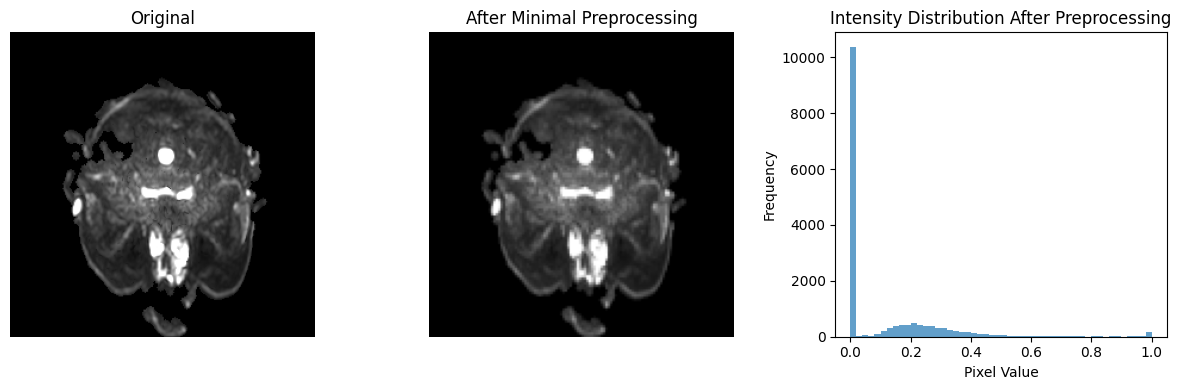

Preprocessed image shape: (128, 128)
Preprocessed value range: 0.000 to 1.000
Data type: float32


In [13]:
def minimal_preprocessing_pipeline(image_path, target_size=(128, 128)):
    """
    Minimal but effective preprocessing for your MRI data
    """
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize if needed
    if image.shape != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0,1] range
    image = image.astype(np.float32) / 255.0
    
    # Optional: Simple intensity clipping to remove outliers
    image = np.clip(image, 0, 1)
    
    return image

# Test the pipeline
test_image = minimal_preprocessing_pipeline(os.path.join(mri_folder, mri_files[0]))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
original = cv2.imread(os.path.join(mri_folder, mri_files[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(original, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_image, cmap='gray')
plt.title('After Minimal Preprocessing')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.hist(test_image.flatten(), bins=50, alpha=0.7)
plt.title('Intensity Distribution After Preprocessing')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Preprocessed image shape: {test_image.shape}")
print(f"Preprocessed value range: {test_image.min():.3f} to {test_image.max():.3f}")
print(f"Data type: {test_image.dtype}")